In [1]:
import re
from datetime import datetime

In [2]:
import sys
sys.path.append('..')
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [3]:
import geopandas as gpd
from pyproj import CRS
from pykml import parser
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [4]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [5]:
gdf_rec

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None
...,...,...,...,...,...,...,...
1614,1409,"MULTILINESTRING ((448682.492 8080612.809, 4486...",900,2025-11-20 20-12-36.tlog,DA03,2243.0,None
1615,1431,"MULTILINESTRING ((473047.575 8093398.477, 4730...",913,2025-11-23 01-19-20.tlog,DA02,2181.0,None
1616,1422,"MULTILINESTRING ((469289.195 8078544.315, 4692...",911,2025-11-22 20-31-39.tlog,DA01,299.0,None
1617,1423,"MULTILINESTRING ((469289.428 8078544.880, 4692...",911,2025-11-22 20-31-39.tlog,DA01,475.0,None


In [6]:
# Directorio donde están los archivos KML
path_kml = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_KML_BIN'
contenido = os.listdir(path_kml)
len(contenido)

86

In [7]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

86

In [8]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [9]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [10]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido_filtrado:
    # directorio + nombre de archivo
    path = path_kml + '\\' + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [11]:
# dic con la geometria y el file_name
data_lineas = {
    'nombre': file_name,
    'vehiculo': ['DA03']*len(file_name),
    'geometry': lineas
}

In [12]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)
gdf_lineas.crs = "EPSG:4326"
gdf_lineas = gdf_lineas.to_crs(epsg=32720)
gdf_lineas

,nombre,vehiculo,geometry
0,Nov-26th-2025-01-09AM-Flight-Airdata.kml,DA03,"LINESTRING (517725.544 8098746.912, 517725.544..."
1,Nov-26th-2025-01-52AM-Flight-Airdata.kml,DA03,"LINESTRING (518320.166 8102147.921, 518320.166..."
2,Nov-26th-2025-02-30AM-Flight-Airdata.kml,DA03,"LINESTRING (518321.835 8102147.931, 518321.846..."
3,Nov-26th-2025-03-00AM-Flight-Airdata.kml,DA03,"LINESTRING (518616.738 8102720.108, 518616.760..."
4,Nov-26th-2025-03-56AM-Flight-Airdata.kml,DA03,"LINESTRING (520158.034 8096333.022, 520158.034..."
...,...,...,...
81,Nov-30th-2025-06-36AM-Flight-Airdata.kml,DA03,"LINESTRING (462201.201 8096754.638, 462201.201..."
82,Nov-30th-2025-07-02AM-Flight-Airdata.kml,DA03,"LINESTRING (462469.284 8097519.677, 462469.295..."
83,Nov-30th-2025-07-39AM-Flight-Airdata.kml,DA03,"LINESTRING (460267.960 8096129.601, 460267.950..."
84,Nov-30th-2025-08-03AM-Flight-Airdata.kml,DA03,"LINESTRING (458517.776 8096917.107, 458517.776..."


<Axes: >

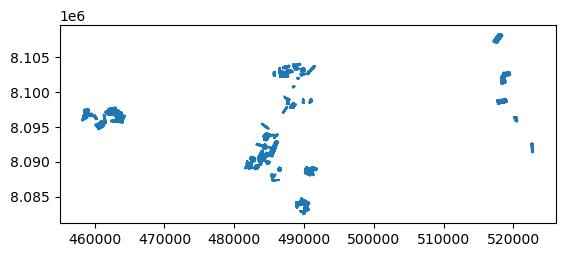

In [13]:
gdf_lineas.plot()

In [14]:
gdf_lineas['num_vert'] = gdf_lineas['geometry'].apply(contar_coordenadas)
gdf_lineas["idd"] = 0
gdf_lines_aux = gdf_lineas.rename_geometry("geom")

In [15]:
gdf_lines_aux

,nombre,vehiculo,geom,num_vert,idd
0,Nov-26th-2025-01-09AM-Flight-Airdata.kml,DA03,"LINESTRING (517725.544 8098746.912, 517725.544...",1345,0
1,Nov-26th-2025-01-52AM-Flight-Airdata.kml,DA03,"LINESTRING (518320.166 8102147.921, 518320.166...",2718,0
2,Nov-26th-2025-02-30AM-Flight-Airdata.kml,DA03,"LINESTRING (518321.835 8102147.931, 518321.846...",1546,0
3,Nov-26th-2025-03-00AM-Flight-Airdata.kml,DA03,"LINESTRING (518616.738 8102720.108, 518616.760...",1395,0
4,Nov-26th-2025-03-56AM-Flight-Airdata.kml,DA03,"LINESTRING (520158.034 8096333.022, 520158.034...",1133,0
...,...,...,...,...,...
81,Nov-30th-2025-06-36AM-Flight-Airdata.kml,DA03,"LINESTRING (462201.201 8096754.638, 462201.201...",1756,0
82,Nov-30th-2025-07-02AM-Flight-Airdata.kml,DA03,"LINESTRING (462469.284 8097519.677, 462469.295...",2031,0
83,Nov-30th-2025-07-39AM-Flight-Airdata.kml,DA03,"LINESTRING (460267.960 8096129.601, 460267.950...",854,0
84,Nov-30th-2025-08-03AM-Flight-Airdata.kml,DA03,"LINESTRING (458517.776 8096917.107, 458517.776...",1778,0


In [16]:
gdf_lines_aux.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)